# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


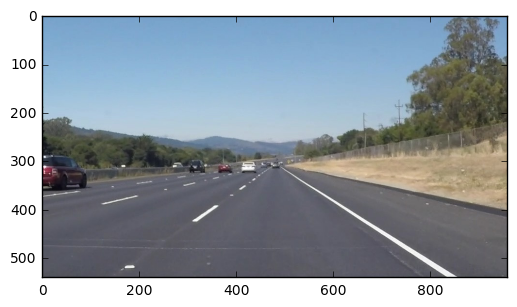

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math
import scipy.misc

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def find_b(points, m):
    return np.mean([y - m*x for x,y in points])
    
def draw_redline(points, img, color, thickness):
    ''''
    Draws the final redline in the image.
    '''
    alpha = 1.5
    
    y1 = img.shape[0]
    y2 = int(img.shape[0]*0.6)                

    vx, vy, x, y = cv2.fitLine(points=points, distType=2,
                                param=0,reps=0.01,aeps=0.01)
    m = float(vy)/vx
    b = find_b(points, m)

    res = np.sqrt(sum([pow((m*x + b)-y,2) for x,y in points])/(len(points)-1))
    
    final = np.array([[x,y] for x,y in points if abs(y - (m*x+b)) < alpha*res])
   
    vx, vy, x, y = cv2.fitLine(points=final, distType=2,
                                param=0,reps=0.01,aeps=0.01)
    m = float(vy)/vx
    b = find_b(final, m)
    x1 = int((y1 - b)/m)
    x2 = int((y2 - b)/m)
    cv2.line(img, (x1, y1),(x2, y2), color, thickness)    
    
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """

    x_half = int(img.shape[1]/2)
    
    points_right = []
    points_left = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            if abs(x2-x1) > 0:
                slope = float(y2-y1)/(x2-x1)
            else:
                continue
            if slope >= 0:
                if x1 < x_half or x2 < x_half:
                    continue
                if slope > .45 and slope < .9:
                    points_right.append([x1,y1])
                    points_right.append([x2,y2])
            else:
                if x1 > x_half or x2 > x_half:
                    continue
                if slope > -.9 and slope < -0.45:
                    points_left.append([x1,y1])
                    points_left.append([x2,y2])

    if len(points_left) > 0:
        draw_redline(np.array(points_left), img, color, thickness)
    if len(points_right) > 0:
        draw_redline(np.array(points_right), img, color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines, thickness=10)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
path = 'test_images/'
outpath = path + 'out/'

In [5]:
#We'll read the image, make it gray scale, blur it to reduce details and facilitate fiding the edges.
#Then we run the edge fiding algorithm (canny) and keep only the edges inside some interesting region.
#We then pass the remaining edges to  Hough transform to find lines.

def pipeline(image, show=False, save=False):
   
    if image.shape[0] != 540:
        image = cv2.resize(image, dsize=(960,540))

    if show:
        plt.imshow(image)
        plt.show()
    
    #make it gray scale
    gray = grayscale(image)
    
    # Define a kernel size for Gaussian smoothing / blurring and make it blurred
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)

    # Define parameters for Canny and run it
    low_threshold = 50
    high_threshold = 70
    edges = canny(blur_gray, low_threshold, high_threshold)

    #Define the vertices of interesting region:
    x = image.shape[1]
    y = image.shape[0]
    horizon = 0.6*y
    vertices = np.array([[(120,y),(450, horizon),(500,horizon),(220, y),
                          (820,y),(500, horizon), (550, horizon), (920,y)]], dtype=np.int32)
    #vertices = np.array([[(0.15*x,y),(0.45*x, horizon),(0.5*x,horizon),(0.5*x, y),
    #                     (0.5*x,y),(0.5*x, horizon), (0.52*x, horizon), (x,y)]], dtype=np.int32)
    #vertices = np.array([[(150,y),(450, 315), (490, 315), (x,y)]], dtype=np.int32)
    edges_masked = region_of_interest(edges, vertices)
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2
    theta = 1*np.pi/180
    threshold = 15
    min_line_len = 20
    max_line_gap = 40
    line_image = np.copy(image)*0 #creating a blank to draw lines on

    # Run Hough on edge detected image
    lines = hough_lines(edges_masked, rho, theta, threshold, min_line_len, max_line_gap)
    
    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges_masked, edges_masked, edges_masked)) 

    # Draw the lines on the edge image
    combo = cv2.addWeighted(color_edges, 0.8, lines, 1, 0) 
    if show:
        plt.imshow(combo)
        plt.show()
    
    combo2 = weighted_img(lines, image, α=0.9, β=1., λ=0.)   
    if show:
        plt.imshow(combo2)
        plt.show()
    if save:
        scipy.misc.imsave(save, combo2)

    return combo2

In [6]:
import os
os.listdir("test_images/")

['.DS_Store',
 'out',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

In [7]:
# List of images we will run our pipeline on:
example_images = [ i for i in os.listdir("test_images/") if i.endswith('.jpg')]

Looking for lanes in image solidWhiteCurve.jpg.


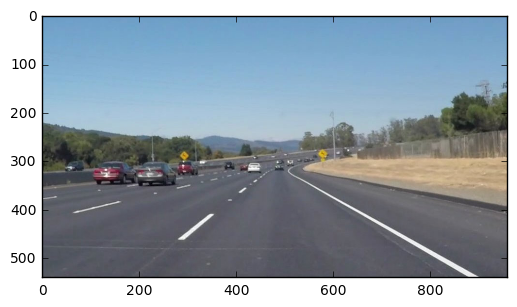

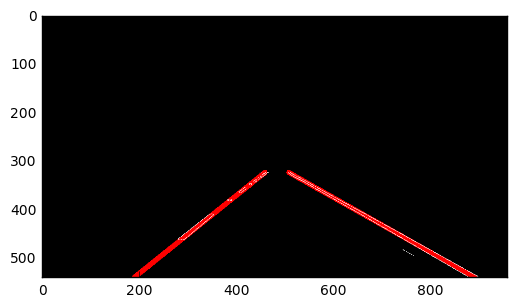

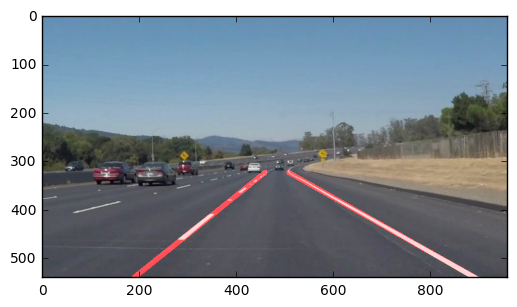

Looking for lanes in image solidWhiteRight.jpg.


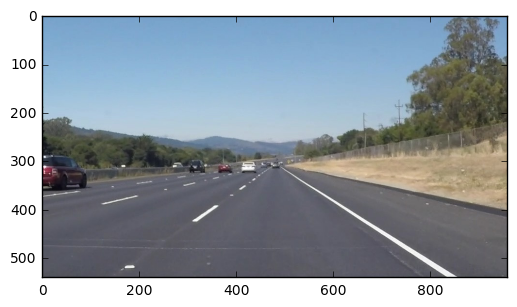

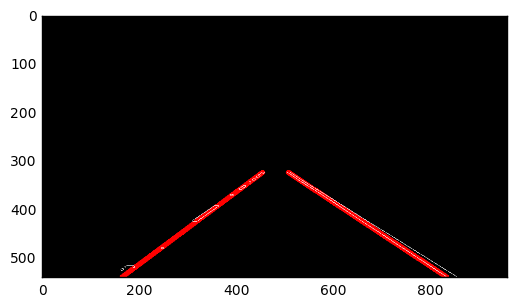

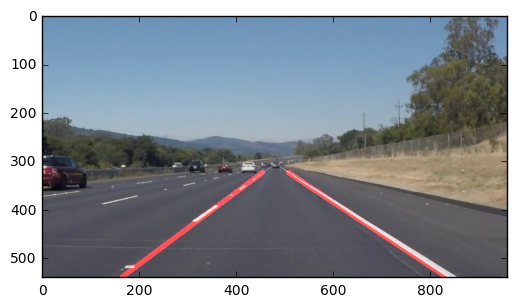

Looking for lanes in image solidYellowCurve.jpg.


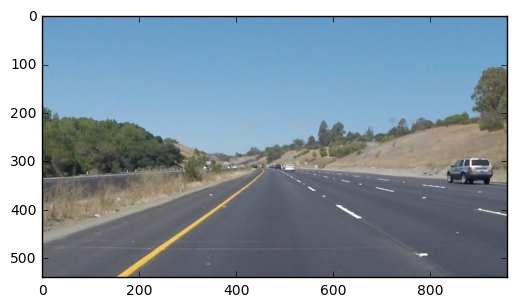

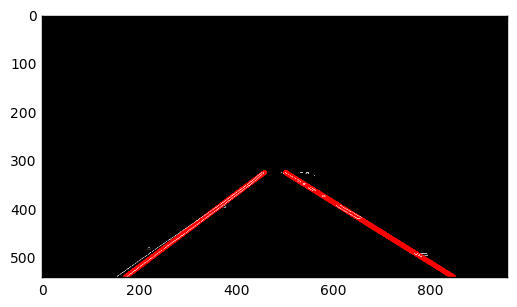

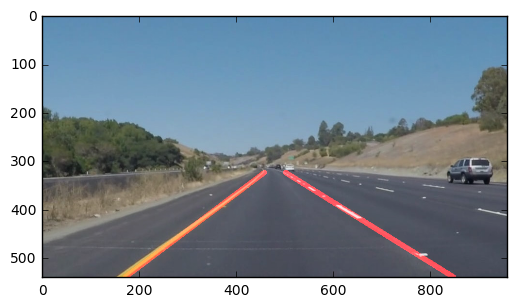

Looking for lanes in image solidYellowCurve2.jpg.


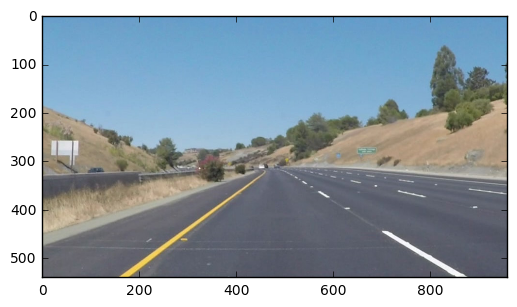

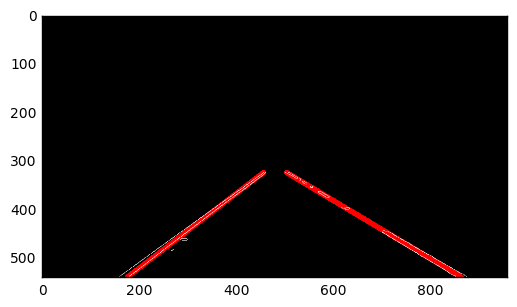

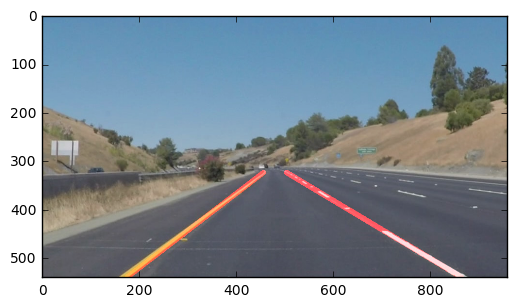

Looking for lanes in image solidYellowLeft.jpg.


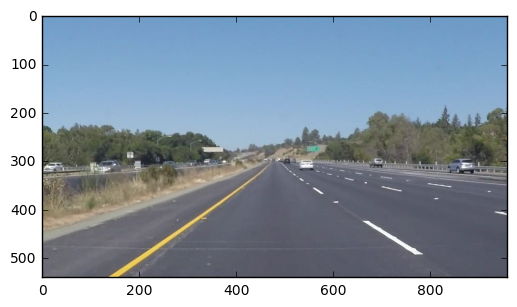

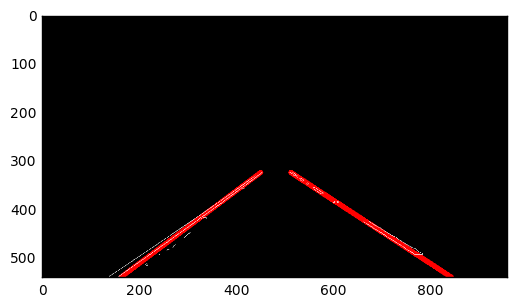

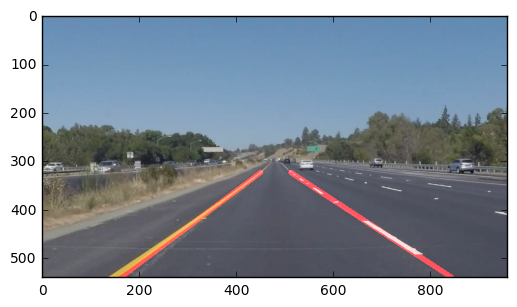

Looking for lanes in image whiteCarLaneSwitch.jpg.


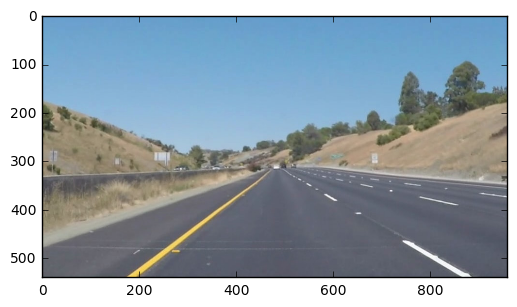

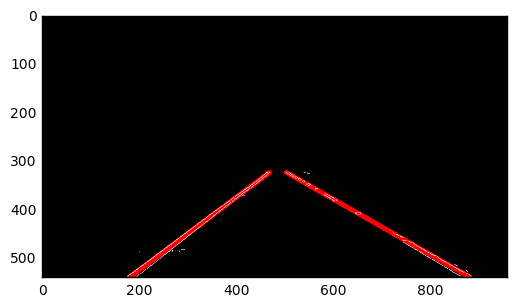

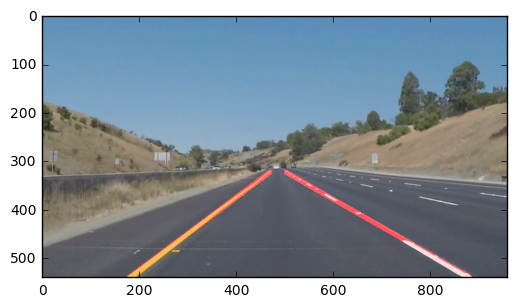

In [8]:
for image in example_images:
    print('Looking for lanes in image {}.'.format(image))
    img_out = ''.join([outpath,'out_',image])
    image = mpimg.imread(path+image)
    dump = pipeline(image,show=True, save=img_out)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [10]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    result = pipeline(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [11]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4", audio=False)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:04<00:00, 50.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 3.97 s, sys: 1.02 s, total: 4.99 s
Wall time: 4.89 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [13]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4', audio=False)
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:14<00:00, 47.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 12.7 s, sys: 3.08 s, total: 15.8 s
Wall time: 14.9 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


#### Reflections:

In this project we build the following pipeline:
- We get an image;
- Make it gray scale;
- Apply Gaussian Blur;
- Find edges in the image (Canny algorithm);
- Select a region of interest ('front' view of the image);
- Find the lines in this region (Hough transform);
- Group all the lines into 2 groups: Left and Right lines;
- Fit a linear function to all the points in the lines in each group;
- Draw a line for each group using the linear fit parameters (I'll give more details later);
- Return the same image with the two lines drawn on top.

Given that it's the first time I play with these sorts of tools for computer vision I am happy with the results, specially applying it to the videos! It was a really cool projecto to work on!
But there's still things I wanna improve. I think the lines still jiggle a bit and it would be a lot nicer to try to make them smoother. I am not sure how I'll try to reduce this. I haven't checked all the parameters exhaustively, I believe there's room for improvement there - possibly in the Canny tresholds.
Also, some of the values we're using are basically hard coded into the pipeline function. I would like to avoid that and write some more robust code to try to find lanes in any image with the only assumption that the lanes are more or less in the center of the image and looking foward.

For example, the video provided for the challenge has different dimensions than the previous 2. Because of the way my region of interested was coded, I had to do a check for the image dimensions and rescale the image to the same dimension as 'expected'. It would be nicer to make it independent of dimension and find some smarter way to define a region of interest without hard coding the numbers there. I played with this idea for a bit just using the total x and y and some proportional values. It must work for any image that scales with (960,540) which is the case of the challenge, but I am not sure how to do it for non-scalling cases.

About the challenge:

I initially thought the difficulty came from the lanes being more curved than the other examples. This might indeed play a role, but the really interesting part is actually when the car crosses the bridge. The color of the asphalt in the bridge is a lot lighter and it's hard for the Canny algorithm to find the edges of the yellow left lane since the gradient does not change as much compared to the darker asphalt. To address that I had to play with the treshold parameters of the Canny function. But since it's the first time I am using computer vision, this is not super intuitive for me. I believe there's still a lot of room for improvement in the choice of these parameters, but I wanna move on for now and continue with the other classes! But hopefully I'll come back to this after learning new things!

One of the problems with lowering the thresholds for fiding the edges was that it includes edges that are not intersting for detecting the lanes. This made the other 2 videos a lot worse. The way I decided to approach this is the following:

- 2 regions of interest;
- filtering the detected points by the Hough transform

So, first I decided to make 2 regions of interest instead of only 1. I choose the vertices such that there are 2 quadrilateral around each lane. This assumes that the detectors will always be looking at the same direction, but I think this is a fair assumption for now. It certainly works for our cases, but one has to consider that when making things more general.
This already removes a lot of unwanted edges.

The second thing that I did was to trim some of the (x,y) points. So, I collect all the points found in the Hough transform in two groups based on the sign of their slope. One for the left lane (negative) and the other for the right (positive). Also the (x,y) for each group has to be on their respective sides of the xy-plane. So in case I find some line with positive slope but on the left half of the image, I won't keep those points. Also, I chose some intervals that the slopes should be.

Once I have these points, I fit a line through them using cv2.fitLine. I then calculated the average residue of all the initial points and this new line and throw out any point that is more than 1.5 times the standard deviation. This is another parameter that I've only played a little bit with. One can improve this even further, but 1.5 seems to be doind a nice job.

This made all 3 videos to have nice performances. I'd say that videos 1 and 2 are doing very nice and the challenge can certainly be improved. I am not sure if curvature plays a big role here, but it is certainly intersting to investigate. But I believe the main sources for the jiggle in the challenge are all the shadows and color changes in the asphalt that makes the lines look confused.

But in conclusion, since this was my first attempt at CV I am very satisfied with these results for now.

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [15]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:07<00:00, 33.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 7.66 s, sys: 1.78 s, total: 9.43 s
Wall time: 8.01 s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))